# Spheroid-Fibroblast 3D Localizations in High-Throughput Microscopy

This notebook demonstrates 3D localizations of fibroblast cluster interacting with cancer spheroids, as shown in the manuscript **Symmetric Cancer Spheroid-Fibroblast Organization Revealed by PSF Engineered High-Throughput 3D Microscopy**.

## Settings

In [1]:
import numpy as np
import pandas as pd
import os
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

from functions.localizations import TP_locations
from functions.crop import diameter_estimation_brightfield, crop_cluster_TP, crop_spheroid_TP
from functions.dfd import localizations_from_dfd

In [2]:
## parameters

crop_spheroid = 700

# parameters for determining spheroid xy location
TP_diff_from_ST_x = -6 
TP_diff_from_ST_y = 0

TP_localization_parameters = {'window_size': 20,
                              'min_distance': 30,
                              'percentile': 98,
                              'gauss_filter': 1,
                              'crop_cluster_cell_wh': 120}

bead_center_slice = 199
num_couple_slices = 200

# dfd
delta_z = 50  # between experimental images
delta_from_each_image = 1 # =1 if z_slice_plus-z_slice_minus=2; =0 if z_slice_plus-z_slice_minus=1;

plot_idx_dfd = 0
save_plot_idx_dfd = 1
crop_bead = 0  # frame width to crop
num_iterations = 4

input_folder = '.\\data\\input'
output_folder = '.\\data\\output'

bead_path = os.path.join(input_folder, 'bead_z_stack.tif')

In [3]:
# generating output folders

frame_with_detections_path = os.path.join(output_folder, 'frames_with_detections')
cropped_images_path = os.path.join(output_folder, 'cropped_detections')

for path in [frame_with_detections_path, cropped_images_path]:
    try:
        os.mkdir(path)
    except:
        pass

## 1. spheroid xy location from brightfield image

In [4]:
brightfield_image_path = os.path.join(input_folder, 'TP_brightfield_C1_z2061_16h.tif')
brightfield_image = cv2.imread(brightfield_image_path, flags=cv2.IMREAD_UNCHANGED)
diameter, centre = diameter_estimation_brightfield(brightfield_image)
delta_c = np.int16(crop_spheroid / 2)
brightfield_image_cropped = brightfield_image[centre[1] - delta_c:centre[1] + delta_c,
                      centre[0] - delta_c:centre[0] + delta_c]


spheroid_start_x = centre[1] - delta_c + TP_diff_from_ST_x
spheroid_start_y = centre[0] - delta_c + TP_diff_from_ST_y


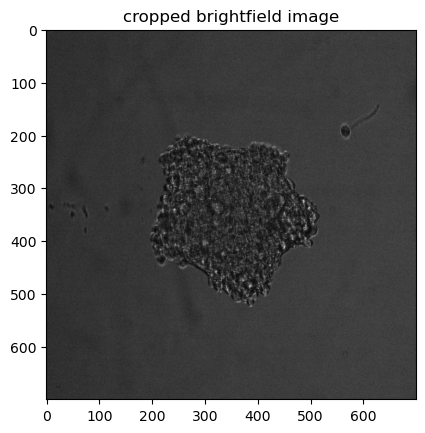

In [5]:
fig1 = plt.figure()
plt.imshow(brightfield_image_cropped, cmap='gray')
# plt.axis('off')
plt.title('cropped brightfield image')
plt.show()


## 2. crop spheroid from TP green images

In [6]:
image_1 = crop_spheroid_TP(image_path=os.path.join(input_folder, 'TP_green_C1_z2011_16h.tif'),
          cropped_spheroid_wh=crop_spheroid,
          spheroid_start_x=spheroid_start_x,
          spheroid_start_y=spheroid_start_y)

image_2 = crop_spheroid_TP(image_path=os.path.join(input_folder, 'TP_green_C1_z2111_16h.tif'),
          cropped_spheroid_wh=crop_spheroid,
          spheroid_start_x=spheroid_start_x,
          spheroid_start_y=spheroid_start_y)


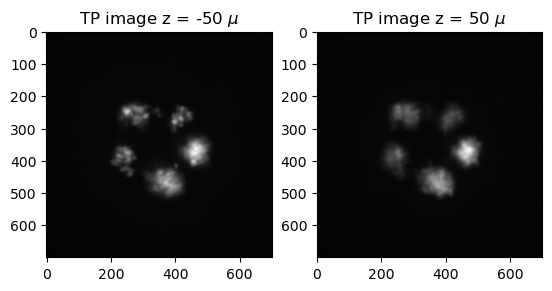

In [7]:
fig2 = plt.figure()
plt.subplot(1,2,1)
plt.imshow(image_1[0,:,:], cmap='gray')
# plt.axis('off')
plt.title('TP image z = -50 $\mu$')

plt.subplot(1,2,2)
plt.imshow(image_2[0,:,:], cmap='gray')
# plt.axis('off')
plt.title('TP image z = 50 $\mu$')
plt.show()

## 3. detecting and cropping clusters

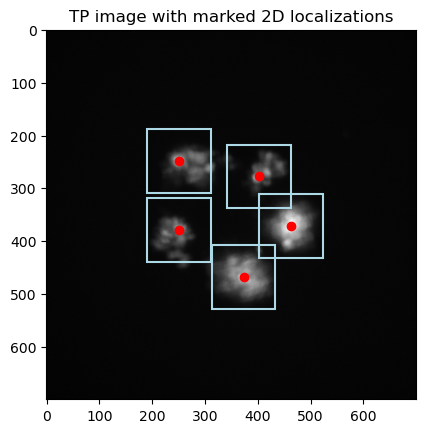

In [8]:
all_locations = np.ones((1, 3))

frame_idx = 0
image_1_detection = image_1[0, :, :]

TP_locations_matrix = TP_locations(image=image_1_detection,
                                   frame_idx=frame_idx,
                                   window_size=TP_localization_parameters['window_size'],
                                   min_distance=TP_localization_parameters['min_distance'],
                                   percentile=TP_localization_parameters['percentile'],
                                   plot=True,
                                   save_plot=True,
                                   save_plot_path=frame_with_detections_path,
                                   gauss_filter=TP_localization_parameters['gauss_filter'],
                                   crop_cluster_cell_wh=TP_localization_parameters['crop_cluster_cell_wh'])

idx_vector = frame_idx * np.ones((TP_locations_matrix.shape[0], 1))
locations_per_idx = np.hstack((idx_vector, TP_locations_matrix))
all_locations = np.vstack((all_locations, locations_per_idx))

plt.close('all')

all_locations = all_locations[1:, :]

columns = ['frame_idx', 'x_TP_location', 'y_TP_location']
all_locations_df = pd.DataFrame(all_locations, columns=columns)
all_locations_df.insert(0, 'localization_index', all_locations_df.index)
all_locations_df.to_csv(os.path.join(output_folder, 'localizations_x_y.csv'),
                        index=False)



In [9]:
# cropping clusters

print('TP image 1')
crop_cluster_TP(all_locations=all_locations_df,
                  image=image_1,
                  crop_cluster_cell_wh=TP_localization_parameters['crop_cluster_cell_wh'],
                  cropped_images_path=cropped_images_path,
                  label='')
print('TP image 2')
crop_cluster_TP(all_locations=all_locations_df,
                  image=image_2,
                  crop_cluster_cell_wh=TP_localization_parameters['crop_cluster_cell_wh'],
                  cropped_images_path=cropped_images_path,
                  label='_plus')


TP image 1
cropping TP clusters...
cluster idx: 0
cluster idx: 1
cluster idx: 2
cluster idx: 3
cluster idx: 4
TP image 2
cropping TP clusters...
cluster idx: 0
cluster idx: 1
cluster idx: 2
cluster idx: 3
cluster idx: 4


## 4. DfD z localizations

In [10]:
localizations_results_df_path = os.path.join(output_folder,'TP_localizations.csv')

columns = ['localization_index', 'TP_z', 'TP_corr_score']

localization_results_df = pd.DataFrame(columns=columns)
localization_results_df.to_csv(localizations_results_df_path, index=False)

localizations_from_dfd(images_path=cropped_images_path,
                       bead_tif_path=bead_path,
                       delta_z=delta_z,
                       bead_center_slice=bead_center_slice,
                       crop_bead=crop_bead,
                       num_couple_slices=num_couple_slices,
                       num_iterations=num_iterations,
                       delta_from_each_image=delta_from_each_image,
                       columns=columns,
                       localizations_results_df_path=localizations_results_df_path)

localizations_results_df = pd.read_csv(localizations_results_df_path)


frame_0000_location_0000.tif
frame_0000_location_0001.tif
frame_0000_location_0002.tif
frame_0000_location_0003.tif
frame_0000_location_0004.tif


In [11]:
print('z-localizations results:\n')
localizations_results_df

z-localizations results:



,localization_index,TP_z,TP_corr_score
0,0.0,3.0,0.987445
1,1.0,-13.0,0.984826
2,2.0,-35.0,0.950076
3,3.0,-18.0,0.947201
4,4.0,-12.0,0.898947
